# 一、项目背景介绍
- 本项目主要是为了介绍RNN以及双向RNN，包含了模型结构、反向传播、梯度消失和梯度爆炸爆炸等知识点。为了便于理解，添加了一个实战项目——基于RNN以及其变体模型的谣言检测任务。实战项目使用了vanilla RNN，lstm，bilstm，gru，bigru五个模型来帮助初学者了解如何从零开始用RNN家族的模型进行文本分类任务。
- 谣言检测任务属于文本分类任务。早期模型一般根据谣言的内容、用户属性、传播方式人工地构造特征，而人工构建特征存在考虑片面、浪费人力等现象。本次项目使用RNN家族的模型进行谣言检测，将文本中的谣言事件向量化，通过循环神经网络的学习训练来挖掘表示文本深层的特征，避免了特征构建的问题，并能发现那些不容易被人发现的特征，从而产生更好的效果。

# 二、数据介绍

## 2.1 数据集概览

本次实践所使用的数据是从新浪微博不实信息举报平台抓取的中文谣言数据，数据集中共包含1538条谣言和1849条非谣言。如下图所示每条数据均为json格式，其中text字段代表微博原文的文字内容。










![](https://ai-studio-static-online.cdn.bcebos.com/dafc017bd02948ada387e1a7e80d97ed1d4144f41a44441494441d69163e4091)
















## 2.2 数据集处理

（1）解压数据，读取并解析数据，生成all_data.txt

（2）生成数据字典，即dict.txt

（3）生成数据列表，并进行训练集与验证集的划分，train_list.txt 、eval_list.txt

（4）定义训练数据集提供器train_reader和验证数据集提供器eval_reader

In [1]:
#解压原始数据集，将Rumor_Dataset.zip解压至data目录下
import zipfile
import os
import random
from PIL import Image
from PIL import ImageEnhance
import json
 
src_path="/home/aistudio/data/data20519/Rumor_Dataset.zip"
target_path="/home/aistudio/data/Chinese_Rumor_Dataset-master"
if(not os.path.isdir(target_path)):
    z = zipfile.ZipFile(src_path, 'r')
    z.extractall(path=target_path)
    z.close()

In [2]:
#分别为谣言数据、非谣言数据、全部数据的文件路径
rumor_class_dirs = os.listdir(target_path+"/Chinese_Rumor_Dataset-master/CED_Dataset/rumor-repost/")
non_rumor_class_dirs = os.listdir(target_path+"/Chinese_Rumor_Dataset-master/CED_Dataset/non-rumor-repost/")
original_microblog = target_path+"/Chinese_Rumor_Dataset-master/CED_Dataset/original-microblog/"

#谣言标签为0，非谣言标签为1
rumor_label="0"
non_rumor_label="1"

#分别统计谣言数据与非谣言数据的总数
rumor_num = 0
non_rumor_num = 0

all_rumor_list = []
all_non_rumor_list = []


#解析谣言数据
for rumor_class_dir in rumor_class_dirs: 
    if(rumor_class_dir != '.DS_Store'):
        #遍历谣言数据，并解析
        with open(original_microblog + rumor_class_dir, 'r') as f:
	        rumor_content = f.read()
        rumor_dict = json.loads(rumor_content)
        all_rumor_list.append(rumor_label+"\t"+rumor_dict["text"]+"\n")
        rumor_num +=1


#解析非谣言数据
for non_rumor_class_dir in non_rumor_class_dirs: 
    if(non_rumor_class_dir != '.DS_Store'):
        with open(original_microblog + non_rumor_class_dir, 'r') as f2:
	        non_rumor_content = f2.read()
        non_rumor_dict = json.loads(non_rumor_content)
        all_non_rumor_list.append(non_rumor_label+"\t"+non_rumor_dict["text"]+"\n")
        non_rumor_num +=1
        
print("谣言数据总量为："+str(rumor_num))
print("非谣言数据总量为："+str(non_rumor_num))


谣言数据总量为：1538
非谣言数据总量为：1849


In [3]:
#全部数据进行乱序后写入all_data.txt

data_list_path="/home/aistudio/data/"
all_data_path=data_list_path + "all_data.txt"

all_data_list = all_rumor_list + all_non_rumor_list # 正负样本列表相加

random.shuffle(all_data_list)  # 打乱list

#在生成all_data.txt之前，首先将其清空
with open(all_data_path, 'w') as f:
    f.seek(0)
    f.truncate() 
    
with open(all_data_path, 'a') as f:
    for data in all_data_list: # 按行写入，一行一个样本
        f.write(data)

# with open(all_data_path,'r',encoding='UTF-8') as f:
#     print(f.read())


In [25]:
# 导入必要的包
%matplotlib inline
import os
from multiprocessing import cpu_count
import numpy as np
import shutil
import paddle
import paddle.fluid as fluid
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False   #用来正常显示负号
from matplotlib.font_manager import FontProperties
font = FontProperties(fname='simhei.ttf', size=16) 

In [5]:
# all_data_path= data_list_path + "all_data.txt"
# data_list_path="/home/aistudio/data/"
# dict_path = data_list_path + "dict.txt"
# 生成数据字典
def create_dict(data_path, dict_path):
    dict_set = set()  # 创建一个无序不重复元素集,集合
    # 读取全部数据
    with open(data_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    # with open('data/test_lines.txt', 'w', encoding='utf-8') as f:
    #     f.write(str(lines))
        #print(lines)
    # 把数据生成一个元组
    for line in lines:
        content = line.split('\t')[-1].replace('\n', '') 
        # 以\t为分隔符，取最后一段。去掉每一行的换行符
        # print(line,content)
        for s in content:
            dict_set.add(s)
            # print(s,dict_set)  #将每一个字加入到一个无序不重复元素集中（元组）
    # 把集合转换成字典，一个字对应一个数字
    dict_list = []
    i = 0
    for s in dict_set:
        dict_list.append([s, i])
        i += 1
    # print(dict_list)
    # 添加未知字符
    dict_txt = dict(dict_list) # list转字典
    end_dict = {"<unk>": i}
    dict_txt.update(end_dict)
    # 把这些字典保存到本地中
    with open(dict_path, 'w', encoding='utf-8') as f:
        f.write(str(dict_txt))
    print("数据字典生成完成！")
    
    
# 获取字典的长度
def get_dict_len(dict_path):
    with open(dict_path, 'r', encoding='utf-8') as f:
        line = eval(f.readlines()[0])
    return len(line.keys())

create_dict('data/all_data.txt','data/dict.txt')
get_dict_len('data/dict.txt')

数据字典生成完成！


4410

In [6]:
# 创建序列化表示的数据,并按照一定比例划分训练数据与验证数据
def create_data_list(data_list_path):
    #在生成数据之前，首先将eval_list.txt和train_list.txt清空
    with open(os.path.join(data_list_path, 'eval_list.txt'), 'w', encoding='utf-8') as f_eval:
        f_eval.seek(0)
        f_eval.truncate()
        
    with open(os.path.join(data_list_path, 'train_list.txt'), 'w', encoding='utf-8') as f_train:
        f_train.seek(0)
        f_train.truncate() 
    
    with open(os.path.join(data_list_path, 'dict.txt'), 'r', encoding='utf-8') as f_data:
        dict_txt = eval(f_data.readlines()[0])
    # print(dict_txt)

    with open(os.path.join(data_list_path, 'all_data.txt'), 'r', encoding='utf-8') as f_data:
        lines = f_data.readlines()
    # print(lines)

    i = 0
    with open(os.path.join(data_list_path, 'eval_list.txt'), 'a', encoding='utf-8') as f_eval,open(os.path.join(data_list_path, 'train_list.txt'), 'a', encoding='utf-8') as f_train:
        for line in lines:
            # print(line)
            words = line.split('\t')[-1].replace('\n', '')
            label = line.split('\t')[0]
            labs = ""
            if i % 8 == 0:
                for s in words:
                    lab = str(dict_txt[s])
                    labs = labs + lab + ','
                labs = labs[:-1]
                labs = labs + '\t' + label + '\n'
                f_eval.write(labs)
            else:
                for s in words:
                    lab = str(dict_txt[s])
                    labs = labs + lab + ','
                labs = labs[:-1]
                labs = labs + '\t' + label + '\n'
                f_train.write(labs)
            i += 1
        
    print("数据列表生成完成！")
create_data_list('/home/aistudio/data/')

数据列表生成完成！


In [7]:
#dict_path为数据字典存放路径
#all_data_path= data_list_path + "all_data.txt"
#data_list_path="/home/aistudio/data/"
dict_path = data_list_path + "dict.txt"

#创建数据字典，存放位置：dict.txt。在生成之前先清空dict.txt
with open(dict_path, 'w') as f:
    f.seek(0)
    f.truncate() 
create_dict(all_data_path, dict_path)

#创建数据列表，存放位置：train_list.txt eval_list.txt
create_data_list(data_list_path)
    

数据字典生成完成！
数据列表生成完成！


In [8]:
def data_mapper(sample):
    data, label = sample
    data = [int(data) for data in data.split(',')]
    return data, int(label)

#定义数据读取器
def data_reader(data_path):
    def reader():
        with open(data_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                data, label = line.split('\t')
                yield data, label
    return paddle.reader.xmap_readers(data_mapper, reader, cpu_count(), 1024)

In [9]:
# 获取训练数据读取器和测试数据读取器
# data_list_path="/home/aistudio/data/"
BATCH_SIZE = 256

train_list_path = data_list_path+'train_list.txt'
eval_list_path = data_list_path+'eval_list.txt'

train_reader = paddle.batch(
		reader=data_reader(train_list_path), 
		batch_size=BATCH_SIZE)
eval_reader = paddle.batch(
		reader=data_reader(eval_list_path), 
		batch_size=BATCH_SIZE)

## 2.3 数据统计分析

In [37]:
# jieba分词
import jieba
import re
with open('data/all_data.txt', mode='r', encoding='utf-8') as f:
    for i in range(10): 
        
        print(f.readline().strip())
    # text = f.read()
    # a=re.findall("[\u4e00-\u9fa5 \n ，。！？：‘’“”【】@]", text)  #数据清洗 只留下正文
    # text="".join(a)  # 连接字符串
    
    # print(a)   
    # seg_list = jieba.cut(text, cut_all=True)    
    # print("[Full Mode]" + "/ ".join(seg_list))     # 全模式

    # seg_list = jieba.cut(text, cut_all=False)
    # print("[Default Mode]" + "/ ".join(seg_list))  # 精确模式

    # seg_list = jieba.cut_for_search(text)          # 搜索引擎模式
    # print("[Search Mode]" + "/ ".join(seg_list))

1	没有节目，没有礼物，只有一句饱含深情的祝福，苗圃，生日快乐！[蛋糕]你已经拥有了人生最好的礼物，我们不跟他（她）争宠[得意地笑]。最好的祝福送给你们！健康！平安！[爱你]
1	有人说，旋转木马是世界上最残忍的游戏，彼此追逐，却怀着永恒的距离。
0	【虐童幼师疑似微博骂网友】颜艳红：我已经反省完了，公安局也让我交5000元罚款姐都交完了，没姐什么事了，你们这些没素质的人就爱骂骂吧，洗澡睡觉，没人搭理你们了，一群没素质没教养的人，祝你们早日车祸撞死。这些绯言绯语，根本不是人话，也不是你们家的孩子，公安局处罚我也交了，有你们什么事呢
0	最新消息，庐山大部分老房子已经坍塌，已有伤亡，成都双流机场一度关闭，为了缓解交通，没紧急事不要前往雅安。四川雅安庐山县地区非紧急情况请尽量少使用移动电话，保证紧急通讯通畅。求扩散！[话筒] [蜡烛]
1	你是不是总是会为了某人而不断地修改自己的底线？不停地为某人找借口，不停地想去原谅……可是，傻孩子，其实TA没那么喜欢你。
0	大家切記！別亂溝女 ..好恐怖好恐怖[吃惊]～@四眼妹Ade 投稿 【更多情侣事，推荐关注@粤语情感线】
0	【7.6万箱含氯可口可乐流入市场】2月初，可口可乐山西饮料公司因管道改造，致使消毒用的含氯处理水混入9批次12万箱可口可乐中，目前确认76391箱流入市场。山西质监局调查事件时发现，该公司以维修电脑为由删除了2月4日到8日部分相关生产记录和全部电邮，关键证人被安排带薪休假。http://t.cn/zY4kOZE
0	[话筒]各位，中央电视台《焦点访谈》已经播出,可口可乐承认旗下[果粒橙]含有美国禁用农药「多菌灵」,现包括香港正在销售的[果粒橙]香港食环署正在了解此事件.专家指出[多菌灵]跟其他农药一样,对脑部影响最大,可引致局部麻痹,并会导致癌症。[心]请火速转给你的朋友，不要给孩子们喝这种饮料 。转
0	✈  经常坐飞机的朋友们：今天才知道，原来20元航空意外保险能赔延误。买机票时购买的20元保险，很多是包含延误险的，飞机延误4小时以上可获得赔偿2000；延误8小时可获赔偿3000元。但是大多数乘客都不知道自己有这些权益，白白的把保费送给了保险公司，个必须转。 很是实用。
1	女人最幸福的时刻，就是嫁对了老公，他纵容着你的习惯，爱着你的一切；女人最幸福的时刻，就是朋友的真心相对，在你最无助时，伸出温暖

In [50]:
#取得文章前5句用jieba分词
import jieba
import re
with open('data/all_data.txt', mode='r', encoding='utf-8') as f:
    for i in range(5): 
        text =f.readline().strip()
        # print(f.readline().strip())
        seg_list = jieba.cut(text, cut_all=True)
        print("[Full Mode]" + "/ ".join(seg_list))     # 全模式

        seg_list = jieba.cut(text, cut_all=False)
        print("[Default Mode]" + "/ ".join(seg_list))  # 精确模式

        seg_list = jieba.cut_for_search(text)          # 搜索引擎模式
        print("[Search Mode]" + "/ ".join(seg_list))

[Full Mode]1/ / 	/ / 没有/ 节目/ ，/ 没有/ 礼物/ ，/ 只有/ 一句/ 饱含/ 深情/ 的/ 祝福/ ，/ 苗圃/ ，/ 生日/ 生日快乐/ 快乐/ ！[/ 蛋糕/ ]/ 你/ 已经/ 拥有/ 了/ 人生/ 最好/ 的/ 礼物/ ，/ 我们/ 不/ 跟/ 他/ （/ 她/ ）/ 争宠/ [/ 得意/ 地/ 笑/ ]。/ 最好/ 的/ 祝福/ 送给/ 你们/ ！/ 健康/ ！/ 平安/ ！[/ 爱/ 你/ ]
[Default Mode]1/ 	/ 没有/ 节目/ ，/ 没有/ 礼物/ ，/ 只有/ 一句/ 饱含/ 深情/ 的/ 祝福/ ，/ 苗圃/ ，/ 生日快乐/ ！/ [/ 蛋糕/ ]/ 你/ 已经/ 拥有/ 了/ 人生/ 最好/ 的/ 礼物/ ，/ 我们/ 不/ 跟/ 他/ （/ 她/ ）/ 争宠/ [/ 得意/ 地笑/ ]/ 。/ 最好/ 的/ 祝福/ 送给/ 你们/ ！/ 健康/ ！/ 平安/ ！/ [/ 爱/ 你/ ]
[Search Mode]1/ 	/ 没有/ 节目/ ，/ 没有/ 礼物/ ，/ 只有/ 一句/ 饱含/ 深情/ 的/ 祝福/ ，/ 苗圃/ ，/ 生日/ 快乐/ 生日快乐/ ！/ [/ 蛋糕/ ]/ 你/ 已经/ 拥有/ 了/ 人生/ 最好/ 的/ 礼物/ ，/ 我们/ 不/ 跟/ 他/ （/ 她/ ）/ 争宠/ [/ 得意/ 地笑/ ]/ 。/ 最好/ 的/ 祝福/ 送给/ 你们/ ！/ 健康/ ！/ 平安/ ！/ [/ 爱/ 你/ ]
[Full Mode]1/ / 	/ / 有人/ 说/ ，/ 旋转/ 木马/ 是/ 世界/ 上/ 最/ 残忍/ 的/ 游戏/ ，/ 彼此/ 追逐/ ，/ 却/ 怀着/ 永恒/ 的/ 距离/ 。
[Default Mode]1/ 	/ 有人/ 说/ ，/ 旋转/ 木马/ 是/ 世界/ 上/ 最/ 残忍/ 的/ 游戏/ ，/ 彼此/ 追逐/ ，/ 却/ 怀着/ 永恒/ 的/ 距离/ 。
[Search Mode]1/ 	/ 有人/ 说/ ，/ 旋转/ 木马/ 是/ 世界/ 上/ 最/ 残忍/ 的/ 游戏/ ，/ 彼此/ 追逐/ ，/ 却/ 怀着/ 永恒/ 的/ 距离/ 。
[Full Mode]0/ / 	/ 【/ 虐/ 童/ 幼师/ 疑似/ 微/ 博/ 骂/ 网友/ 】/ 

In [47]:
# jieba词频统计
from jieba import analyse

extract_tags = analyse.extract_tags(text, withWeight=True)
for i, j in extract_tags:
    print(i, j)

幸福 0.5374818896842106
时刻 0.5342669760852632
女人 0.43734241134868423
父母 0.33621368985789474
就是 0.2840667716636842
唠唠叨叨 0.2832943009473684
几米 0.26563197795263155
爱着 0.26505358567105264
一切 0.2629713112952632
无助 0.25218919838
漫画 0.24384075430921054
纵容 0.23731251919447366
陶醉 0.23176124871500003
老公 0.21927192495289471
真心 0.21867607030157896
安心 0.20807147959657896
伸出 0.18765883355578947
温暖 0.18469053107842107
享受 0.16885023707078947
多么 0.16741185779342105


In [ ]:
!pip install wordcloud

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


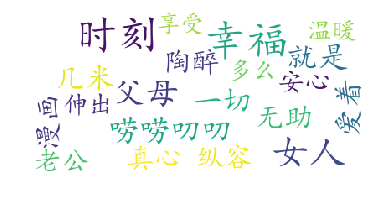

In [48]:
# 词云可视化

from wordcloud import WordCloud

result = {}
for word in extract_tags:
    result[word[0]] = word[1]

wordcloud = WordCloud(
    background_color="white",
    max_font_size=50,
    font_path='work/simkai.ttf')
wordcloud.generate_from_frequencies(result)

plt.figure()
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# 三、模型介绍
<br/>本项目主要是为了讲解RNN以及BRNN，所以使用了vanilla RNN，lstm，bilstm，gru，bigru五个模型进行谣言分类任务。其中包含embedding层进行文本向量化，rnn层进行文本语义特征提取，全连接层进行层间的衔接或者最后的分类，用softmax层将最后结果映射到二维向量上。batchsize设置为256，epoch设置为50。

## 3.1 搭建网络

In [10]:
def rnn_net(ipt, input_dim): #   循环神经网络
    # 以数据的IDs作为输入   ipt 输入 数据集 
    emb = fluid.layers.embedding(input=ipt, size=[input_dim, 128],is_sparse=True)
    drnn = fluid.layers.DynamicRNN()
    with drnn.block():
        # 将embedding标记为RNN的输入，每个时间步取句子中的一个字进行处理
        word=drnn.step_input(emb)
        # 将memory初始化为一个值为0的常量Tensor，shape=[batch_size, 200]，其中batch_size由输入embedding决定
        memory = drnn.memory(shape=[200])
        hidden = fluid.layers.fc(input=[word, memory], size=200, act='relu')
        # 用hidden更新memory
        drnn.update_memory(ex_mem=memory, new_mem=hidden)
        # 将hidden标记为RNN的输出
        drnn.output(hidden)
    
    # 最大序列池操作
    fc = fluid.layers.sequence_pool(input=drnn(), pool_type='max')

    # 以softmax作为全连接的输出层，大小为2,也就是正负面
    out = fluid.layers.fc(input=fc, size=2, act='softmax')
    return out

In [11]:
def lstm_net(ipt, input_dim): # 长短期记忆网络

    # 以数据的IDs作为输入

    emb = fluid.layers.embedding(input=ipt, size=[input_dim, 128], is_sparse=True)

    # 第一个全连接层

    fc1 = fluid.layers.fc(input=emb, size=128)

    # 进行一个长短期记忆操作

    lstm1, _ = fluid.layers.dynamic_lstm(input=fc1, #返回：隐藏状态（hidden state），LSTM的神经元状态

                                         size=128) #size=4*hidden_size

    # 第一个最大序列池操作

    fc2 = fluid.layers.sequence_pool(input=fc1, pool_type='max')

    # 第二个最大序列池操作

    lstm2 = fluid.layers.sequence_pool(input=lstm1, pool_type='max')

    # 以softmax作为全连接的输出层，大小为2,也就是正负面

    out = fluid.layers.fc(input=[fc2, lstm2], size=2, act='softmax')

    return out

In [12]:
def bilstm_net(ipt, input_dim): # 双向长短期神经网络
    # 以数据的IDs作为输入
    emb = fluid.layers.embedding(input=ipt, size=[input_dim, 128], is_sparse=True)
    # 第一个全连接层
    fc1_f = fluid.layers.fc(input=emb, size=128)
    fc1_b = fluid.layers.fc(input=emb, size=128)
    # 进行一个长短期记忆操作
    lstm1_f, _ = fluid.layers.dynamic_lstm(input=fc1_f, #返回：隐藏状态（hidden state），LSTM的神经元状态
                                         size=128) #size=4*hidden_size
    lstm1_b, _ = fluid.layers.dynamic_lstm(input=fc1_b, #返回：隐藏状态（hidden state），LSTM的神经元状态
                                        is_reverse = True,                
                                         size=128) #size=4*hidden_size                                     
    # 第一个最大序列池操作
    fc2_f = fluid.layers.sequence_pool(input=fc1_f, pool_type='max')
    fc2_b = fluid.layers.sequence_pool(input=fc1_b, pool_type='max')
    # 第二个最大序列池操作
    lstm2_f = fluid.layers.sequence_pool(input=lstm1_f, pool_type='max')
    lstm2_b = fluid.layers.sequence_pool(input=lstm1_b, pool_type='max')

    lstm2 = fluid.layers.concat(input=[lstm2_f, lstm2_b], axis=1)
    fc2 = fluid.layers.concat(input=[fc2_f, fc2_b], axis=1)
    # 以softmax作为全连接的输出层，大小为2,也就是正负面
    out = fluid.layers.fc(input=[fc2, lstm2], size=2, act='softmax')
    return out

In [13]:
def gru_net(ipt, input_dim): # 门控循环单元
    # 以数据的IDs作为输入
    emb = fluid.layers.embedding(input=ipt, size=[input_dim, 128], is_sparse=True)
    # 第一个全连接层
    fc1 = fluid.layers.fc(input=emb, size=384)
    # 进行一个长短期记忆操作
    gru1= fluid.layers.dynamic_gru(input=fc1,size=128)
    # 第一个最大序列池操作
    fc2 = fluid.layers.sequence_pool(input=fc1, pool_type='max')
    # 第二个最大序列池操作
    gru2 = fluid.layers.sequence_pool(input=gru1, pool_type='max')
    # 以softmax作为全连接的输出层，大小为2,也就是正负面
    out = fluid.layers.fc(input=[fc2, gru2], size=2, act='softmax')
    return out

In [14]:
def bigru_net(ipt, input_dim): # 双向门控循环单元
    # 以数据的IDs作为输入
    emb = fluid.layers.embedding(input=ipt, size=[input_dim, 128], is_sparse=True)
    # 第一个全连接层
    fc1_f = fluid.layers.fc(input=emb, size=384)
    fc1_b = fluid.layers.fc(input=emb, size=384)
    # 进行一个长短期记忆操作
    gru1_f= fluid.layers.dynamic_gru(input=fc1_f,size=128)
    gru1_b= fluid.layers.dynamic_gru(input=fc1_b,size=128,is_reverse=True)
    
    # 第一个最大序列池操作
    fc2_f = fluid.layers.sequence_pool(input=fc1_f, pool_type='max')
    fc2_b = fluid.layers.sequence_pool(input=fc1_b, pool_type='max')
    
    # 第二个最大序列池操作
    gru2_f = fluid.layers.sequence_pool(input=gru1_f, pool_type='max')
    gru2_b = fluid.layers.sequence_pool(input=gru1_b, pool_type='max')
    
    gru2 = fluid.layers.concat(input=[gru2_f, gru2_b], axis=1)
    fc2 = fluid.layers.concat(input=[fc2_f, fc2_b], axis=1)

    # 以softmax作为全连接的输出层，大小为2,也就是正负面
    out = fluid.layers.fc(input=[fc2, gru2], size=2, act='softmax')
    return out

## 3.2 定义数据层

In [15]:
# 定义输入数据， lod_level不为0指定输入数据为序列数据
paddle.enable_static()
words = fluid.data(name='words', shape=[None,1], dtype='int64', lod_level=1) 
label = fluid.data(name='label', shape=[None,1], dtype='int64') 



## 3.3 获取分类器

In [16]:
# 获取数据字典长度
dict_dim = get_dict_len(dict_path)
# 获取分类器
# model = rnn_net(words, dict_dim) 
# model = lstm_net(words, dict_dim) 
# model = bilstm_net(words, dict_dim) 
# model = gru_net(words, dict_dim) 
model = bigru_net(words, dict_dim) 



## 3.4 定义损失函数和准确率

定义了一个损失函数之后，还有对它求平均值，因为定义的是一个Batch的损失值。

同时我们还可以定义一个准确率函数，这个可以在我们训练的时候输出分类的准确率。

In [17]:
# 获取损失函数和准确率
cost = fluid.layers.cross_entropy(input=model, label=label)
avg_cost = fluid.layers.mean(cost)
acc = fluid.layers.accuracy(input=model, label=label)
# 获取预测程序
test_program = fluid.default_main_program().clone(for_test=True)

## 3.5 定义优化方法

In [18]:
# 定义优化方法
optimizer = fluid.optimizer.AdagradOptimizer(learning_rate=0.001)
opt = optimizer.minimize(avg_cost)

# 四、模型训练
## 4.1 创建Executor

In [19]:
# use_cuda为False,表示运算场所为CPU;use_cuda为True,表示运算场所为GPU 
use_cuda = True 
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)  
# 进行参数初始化
exe.run(fluid.default_startup_program())


W0222 18:50:51.829311   733 device_context.cc:404] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0222 18:50:51.834461   733 device_context.cc:422] device: 0, cuDNN Version: 7.6.


[]

## 4.2 定义数据映射器


DataFeeder负责将数据提供器（train_reader,test_reader）返回的数据转成一种特殊的数据结构，使其可以输入到Executor中。

feed_list设置向模型输入的向变量表或者变量表名

In [20]:
# 定义数据映射器
feeder = fluid.DataFeeder(place=place, feed_list=[words, label])

## 4.3 展示模型训练曲线

In [21]:
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

all_eval_iter=0
all_eval_iters=[]
all_eval_costs=[]
all_eval_accs=[]


def draw_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("cost/acc", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()


## 4.4 训练并保存模型

Executor接收传入的program,并根据feed map(输入映射表)和fetch_list(结果获取表) 向program中添加feed operators(数据输入算子)和fetch operators（结果获取算子)。

feed map为该program提供输入数据。fetch_list提供program训练结束后用户预期的变量。

每一轮训练结束之后，再使用验证集进行验证，并求出相应的损失值Cost和准确率acc。

epoch: 1
Pass:0, Batch:0, Cost:0.69203, Acc:0.51953
Pass:0, Batch:10, Cost:0.67014, Acc:0.50391
Test:0, Cost:0.65510, ACC:0.71168
epoch: 2
Pass:1, Batch:0, Cost:0.64882, Acc:0.74219
Pass:1, Batch:10, Cost:0.64281, Acc:0.67578
Test:1, Cost:0.63516, ACC:0.79436
epoch: 3
Pass:2, Batch:0, Cost:0.62226, Acc:0.82031
Pass:2, Batch:10, Cost:0.61685, Acc:0.76953
Test:2, Cost:0.61762, ACC:0.79436
epoch: 4
Pass:3, Batch:0, Cost:0.60022, Acc:0.82812
Pass:3, Batch:10, Cost:0.60002, Acc:0.80078
Test:3, Cost:0.60166, ACC:0.79343
epoch: 5
Pass:4, Batch:0, Cost:0.58065, Acc:0.82422
Pass:4, Batch:10, Cost:0.57921, Acc:0.82031
Test:4, Cost:0.58692, ACC:0.80218
epoch: 6
Pass:5, Batch:0, Cost:0.56075, Acc:0.82812
Pass:5, Batch:10, Cost:0.56342, Acc:0.83203
Test:5, Cost:0.57275, ACC:0.80227
epoch: 7
Pass:6, Batch:0, Cost:0.54153, Acc:0.83984
Pass:6, Batch:10, Cost:0.54354, Acc:0.83984
Test:6, Cost:0.55704, ACC:0.81017
epoch: 8
Pass:7, Batch:0, Cost:0.52437, Acc:0.83984
Pass:7, Batch:10, Cost:0.52121, Acc:0.

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


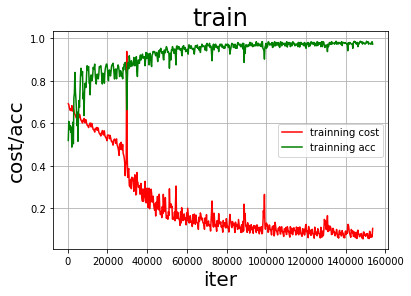

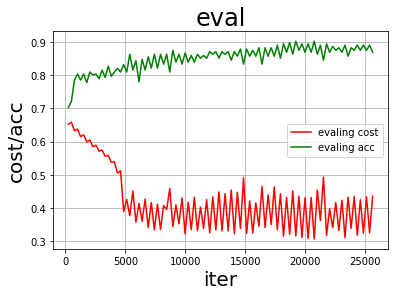

In [22]:
EPOCH_NUM=50                                       #训练轮数
model_save_dir = '/home/aistudio/work/infer_model/' #模型保存路径
# 开始训练

for pass_id in range(EPOCH_NUM):
    # 进行训练
    print('epoch:',int(pass_id)+1)
    for batch_id, data in enumerate(train_reader()):
        train_cost, train_acc = exe.run(program=fluid.default_main_program(),
                             feed=feeder.feed(data),
                             fetch_list=[avg_cost, acc])
        all_train_iter=all_train_iter+BATCH_SIZE
        all_train_iters.append(all_train_iter)
        all_train_costs.append(train_cost[0])
        all_train_accs.append(train_acc[0])
        
        if batch_id % 10 == 0:
            print('Pass:%d, Batch:%d, Cost:%0.5f, Acc:%0.5f' % (pass_id, batch_id, train_cost[0], train_acc[0]))
    # 进行验证
    eval_costs = []
    eval_accs = []
    for batch_id, data in enumerate(eval_reader()):
        eval_cost, eval_acc = exe.run(program=test_program,
                                              feed=feeder.feed(data),
                                              fetch_list=[avg_cost, acc])
        eval_costs.append(eval_cost[0])
        eval_accs.append(eval_acc[0])
        
        all_eval_iter=all_eval_iter+BATCH_SIZE
        all_eval_iters.append(all_eval_iter)
        all_eval_costs.append(eval_cost[0])                                       
        all_eval_accs.append(eval_acc[0])      
    # 计算平均预测损失在和准确率
    eval_cost = (sum(eval_costs) / len(eval_costs))
    eval_acc = (sum(eval_accs) / len(eval_accs))
    print('Test:%d, Cost:%0.5f, ACC:%0.5f' % (pass_id, eval_cost, eval_acc))

# 保存模型
if not os.path.exists(model_save_dir): 
    os.makedirs(model_save_dir) 
fluid.io.save_inference_model(model_save_dir, 
                            feeded_var_names=[words.name], 
                            target_vars=[model], 
                            executor=exe)
print('训练模型保存完成！') 

draw_process("train",all_train_iters,all_train_costs,all_train_accs,"trainning cost","trainning acc")
draw_process("eval",all_eval_iters,all_eval_costs,all_eval_accs,"evaling cost","evaling acc")


# 五、模型评估
模型在训练时同时输出了在验证集上的评估结果，见上方训练输出图像。下方代码展示模型预测效果


In [23]:
# 用训练好的模型进行预测并输出预测结果
# 创建执行器
place = fluid.CPUPlace()
infer_exe = fluid.Executor(place)
infer_exe.run(fluid.default_startup_program())

save_path = '/home/aistudio/work/infer_model/'

# 从模型中获取预测程序、输入数据名称列表、分类器
[infer_program, feeded_var_names, target_var] = fluid.io.load_inference_model(dirname=save_path, executor=infer_exe)


# 获取数据
def get_data(sentence):
    # 读取数据字典
    with open('/home/aistudio/data/dict.txt', 'r', encoding='utf-8') as f_data:
        dict_txt = eval(f_data.readlines()[0])
    dict_txt = dict(dict_txt)
    # 把字符串数据转换成列表数据
    keys = dict_txt.keys()
    data = []
    for s in sentence:
        # 判断是否存在未知字符
        if not s in keys:
            s = '<unk>'
        data.append(int(dict_txt[s]))
    return data


data = []
# 获取图片数据
data1 = get_data('兴仁县今天抢小孩没抢走，把孩子母亲捅了一刀，看见这车的注意了，真事，车牌号辽HFM055！！！！！赶紧散播！ 都别带孩子出去瞎转悠了 尤其别让老人自己带孩子出去 太危险了 注意了！！！！辽HFM055北京现代朗动，在各学校门口抢小孩！！！110已经 证实！！全市通缉！！')
data2 = get_data('重庆真实新闻:2016年6月1日在重庆梁平县袁驿镇发生一起抢儿童事件，做案人三个中年男人，在三中学校到镇街上的一条小路上，把小孩直接弄晕(儿童是袁驿新幼儿园中班的一名学生)，正准备带走时被家长及时发现用棒子赶走了做案人，故此获救！请各位同胞们以此引起非常重视，希望大家有爱心的人传递下')
data3 = get_data('@尾熊C 要提前预习育儿知识的话，建议看一些小巫写的书，嘻嘻')
data.append(data1)
data.append(data2)
data.append(data3)

# 获取每句话的单词数量
base_shape = [[len(c) for c in data]]

# 生成预测数据
tensor_words = fluid.create_lod_tensor(data, base_shape, place)

# 执行预测
result = exe.run(program=infer_program,
                 feed={feeded_var_names[0]: tensor_words},
                 fetch_list=target_var)

# 分类名称
names = [ '谣言', '非谣言']

# 获取结果概率最大的label
for i in range(len(data)):
    lab = np.argsort(result)[0][i][-1]
    print('预测结果标签为：%d， 分类为：%s， 概率为：%f' % (lab, names[lab], result[0][i][lab]))

预测结果标签为：0， 分类为：谣言， 概率为：0.997949
预测结果标签为：0， 分类为：谣言， 概率为：0.994011
预测结果标签为：1， 分类为：非谣言， 概率为：0.531892


# 六、总结与升华
本项目基于paddle框架，使用了RNN家族的模型，详细介绍了从数据集的处理再到模型的搭建，最后到模型的评估。适合想系统了解循环神经网络并且增加项目实战经验的初学者。但是也存在着一定的不足，例如数据集比较小，使用复杂的模型容易过拟合。后期可能会更换更大的数据集或者使用数据集增强，然后使用更加复杂的模型比如预训练模型，或者加入注意力机制。

# 七、个人总结

> 作者 ： f_g

> 研究方向 ：多模态，假新闻检测

> 深度学习初学者，比赛新手。希望可以在paddlepaddle提供的平台上广结良师益友互相学习共同进步。

> 我在AI Studio上获得白银等级，点亮2个徽章，来互关呀~ https://aistudio.baidu.com/aistudio/personalcenter/thirdview/788652